# MNIST Explore Classifiers

#### IMPORT'S

In [1]:
import numpy as np
import keras
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten,Dropout
from keras.models import Sequential, Model
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.constraints import maxnorm
from keras.datasets import mnist
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Using TensorFlow backend.


## 1. Download MNIST dataset

In [11]:
from keras.datasets import mnist

# Load the mnist pre-shuffled train data and test data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

input_size = x_train.shape[1]*x_train.shape[2] #input size for input shape function
input_shape = (x_train.shape[1],x_train.shape[2], ) #input shape for input 
input_img= Input(shape=(input_size,))   #Take the input image of dimension 784 and convert it to keras tensors.

classes = np.unique(y_train)
num_classes = len(classes) # No of unique classes for classification

# convert y to categorical variable (vector)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Transform from matrix to vector
x_train = x_train.astype('float32')
# Normalize inputs from 0-255 to 0.0-1.0
x_train /= 255

# Transform from matrix to vector
x_test = x_test.astype('float32')
# Normalize inputs from 0-255 to 0.0-1.0
x_test /= 255

Loading the MNIST dataset images, We are going to reconstruct the images as output of the autoencoder.

Creating a training set and test set and normalizing the data to train the model better.

#### 1.1 Displaying the shape of training and test dataset and number of classes 

In [3]:
print("Training Data : ",x_train.shape)
print("Testing Data : ",x_test.shape)
print("Number of Classes : ",num_classes)

Training Data :  (60000, 28, 28)
Testing Data :  (10000, 28, 28)
Number of Classes :  10


Printing the shape of training and test dataset and number of classes

#### ** EarlyStopping and ModelCheckpoint **

In [5]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)
checkpoint= ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.

monitor - performance measure to monitor in order to end training ,mode - minimize loss or maximize accuracy, To discover the training epoch on which training was stopped, the “verbose” argument can be set to 1. Once stopped, the callback will print the epoch number.

ModelCheckpoint callback - we will save the best model observed during training for later use


#### HYPER PARAMETERS

In [23]:
# define the grid search parameters
#batch_size = [8, 16, 32, 64, 128, 256, 512, 1024]
gridSearch_batch_Size = [16, 32, 64]

#epochs = [10, 50, 100,500,1000]
gridSearch_epochs = [10,20,30]

#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
gridSearch_optimizer = [ 'Adadelta', 'Adam']

#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
gridSearch_learn_rate = [0.001,0.01, 0.1, 0.2,0.3]

#activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
gridSearch_activation = ['softmax', 'relu', 'sigmoid']

#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gridSearch_dropout_rate = [0.1, 0.4,0.9]

#neurons = [8, 16, 32, 64, 128, 256, 512, 1024]
gridSearch_neurons = [32, 64, 128]

param_grid = dict(batch_size=gridSearch_batch_Size
                  ,neurons=gridSearch_neurons
                  ,dropout_rate=gridSearch_dropout_rate
                  ,epochs=gridSearch_epochs
                  ,optimizer=gridSearch_optimizer 
                  ,learn_rate=gridSearch_learn_rate 
                  ,activation=gridSearch_activation)

init_mode='uniform'
momentum=0

Initializing the parameter for future use purpose

## 2. MNIST classifier

### 2.1.1 Definition of Image Classifier Model

In [7]:
def create_model(neurons=784,dropout_rate=0.5,
                 init_mode='uniform',
                 optimizer='adam', learn_rate=0.01, momentum=0,
                 activation='relu'): 
    # create model
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)
    x = Dense(neurons,kernel_initializer=init_mode,activation=activation)(x)
    x = Dense(128,kernel_initializer=init_mode,activation=activation)(x)
    x = Dense(64,kernel_initializer=init_mode,activation=activation)(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes,kernel_initializer=init_mode,activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Configures the model for training.
    # optimizer = optimizer(lr=learn_rate, momentum=momentum)
    # Optimizer     -- Adam
    # Loss function -- Binary cross entropy
    # Metrics       -- Accuracy
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Creating the image classifier model for KerasClassifier on original dataset

we encode the original data to 64 input data by applying different hidden layers to model.

The output layer needs to predict the probability of an output using sigmoid function.

For all the hidden layers for the model we use relu activation function for non-linearity.

We compile the model with adam optimizer.

As pixels have a value of 0 0r 1 we use binary_crossentropy as the loss function

We use accuracy as the metrics used for the performance of the model.

### 2.1.2 Building  a KerasClassifier for GridSearchCV

In [8]:
model = KerasClassifier(build_fn=create_model, verbose=2)

To use these wrappers you must define a function that creates and returns your Keras sequential model, then pass this function to the build_fn argument when constructing the KerasClassifier class.

#### 2.1.3 Apply GridSearchCV on KerasClassifier for best results

In [9]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

The GridSearchCV process will then construct and evaluate one model for each combination of parameters.
Cross validation is used to evaluate each individual model and the default of 3-fold cross validation is used, although this can be overridden by specifying the cv argument to the GridSearchCV constructor.

GridSearch is to find the better hyper parameter 

#### 2.1.4 Fitting the gridsearchcv 

It return best score parameters

In [10]:
# We use only a small part of the dataset
grid_result = grid.fit(x_train[:1000], y_train[:1000], verbose=2)

C:\Users\krant\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/30
 - 1s - loss: 0.3234 - accuracy: 0.9000
Epoch 2/30
 - 0s - loss: 0.2969 - accuracy: 0.9004
Epoch 3/30
 - 0s - loss: 0.2744 - accuracy: 0.9029
Epoch 4/30
 - 0s - loss: 0.2571 - accuracy: 0.9056
Epoch 5/30
 - 0s - loss: 0.2346 - accuracy: 0.9124
Epoch 6/30
 - 0s - loss: 0.2342 - accuracy: 0.9116
Epoch 7/30
 - 0s - loss: 0.2200 - accuracy: 0.9178
Epoch 8/30
 - 0s - loss: 0.2105 - accuracy: 0.9200
Epoch 9/30
 - 0s - loss: 0.2034 - accuracy: 0.9195
Epoch 10/30
 - 0s - loss: 0.2062 - accuracy: 0.9198
Epoch 11/30
 - 0s - loss: 0.1981 - accuracy: 0.9224
Epoch 12/30
 - 0s - loss: 0.1967 - accuracy: 0.9227
Epoch 13/30
 - 0s - loss: 0.1865 - accuracy: 0.9246
Epoch 14/30
 - 0s - loss: 0.1834 - accuracy: 0.9277
Epoch 15/30
 - 0s - loss: 0.1719 - accuracy: 0.9316
Epoch 16/30
 - 0s - loss: 0.1756 - accuracy: 0.9304
Epoch 17/30
 - 0s - loss: 0.1684 - accuracy: 0.9341
Epoch 18/30
 - 0s - loss: 0.16

In [11]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.971800 using {'activation': 'relu', 'batch_size': 16, 'dropout_rate': 0.9, 'epochs': 30, 'learn_rate': 0.01, 'neurons': 128, 'optimizer': 'Adam'}


#### 2.1.5 Summarize Results

In [12]:
means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
print("mean\t\tparams")
print("--------------------------------")
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

mean		params
--------------------------------
0.900000 with: {'activation': 'softmax', 'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 10, 'learn_rate': 0.001, 'neurons': 32, 'optimizer': 'Adadelta'}
0.900000 with: {'activation': 'softmax', 'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 10, 'learn_rate': 0.001, 'neurons': 32, 'optimizer': 'Adam'}
0.900000 with: {'activation': 'softmax', 'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 10, 'learn_rate': 0.001, 'neurons': 64, 'optimizer': 'Adadelta'}
0.900000 with: {'activation': 'softmax', 'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 10, 'learn_rate': 0.001, 'neurons': 64, 'optimizer': 'Adam'}
0.900000 with: {'activation': 'softmax', 'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 10, 'learn_rate': 0.001, 'neurons': 128, 'optimizer': 'Adadelta'}
0.900000 with: {'activation': 'softmax', 'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 10, 'learn_rate': 0.001, 'neurons': 128, 'optimizer': 'Adam'}
0.900000 with: {'activation': 'sof

0.942600 with: {'activation': 'sigmoid', 'batch_size': 16, 'dropout_rate': 0.4, 'epochs': 30, 'learn_rate': 0.3, 'neurons': 64, 'optimizer': 'Adam'}
0.900000 with: {'activation': 'sigmoid', 'batch_size': 16, 'dropout_rate': 0.4, 'epochs': 30, 'learn_rate': 0.3, 'neurons': 128, 'optimizer': 'Adadelta'}
0.949300 with: {'activation': 'sigmoid', 'batch_size': 16, 'dropout_rate': 0.4, 'epochs': 30, 'learn_rate': 0.3, 'neurons': 128, 'optimizer': 'Adam'}
0.900000 with: {'activation': 'sigmoid', 'batch_size': 16, 'dropout_rate': 0.9, 'epochs': 10, 'learn_rate': 0.001, 'neurons': 32, 'optimizer': 'Adadelta'}
0.900000 with: {'activation': 'sigmoid', 'batch_size': 16, 'dropout_rate': 0.9, 'epochs': 10, 'learn_rate': 0.001, 'neurons': 32, 'optimizer': 'Adam'}
0.900000 with: {'activation': 'sigmoid', 'batch_size': 16, 'dropout_rate': 0.9, 'epochs': 10, 'learn_rate': 0.001, 'neurons': 64, 'optimizer': 'Adadelta'}
0.900000 with: {'activation': 'sigmoid', 'batch_size': 16, 'dropout_rate': 0.9, 'epoch

Save best result into file

In [13]:
from sklearn.externals import joblib
joblib.dump(grid_result, 'gridSearchCV.pkl')

C:\Users\krant\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['gridSearchCV.pkl']

Load Best parameters from file 

In [40]:
grid_result = joblib.load('gridSearchCV.pkl')

activation = grid_result.best_params_['activation']
batch_size = grid_result.best_params_['batch_size']
dropout_rate = grid_result.best_params_['dropout_rate']
epochs = grid_result.best_params_['epochs']
learn_rate = grid_result.best_params_['learn_rate']
neurons = grid_result.best_params_['neurons']
optimizer = grid_result.best_params_['optimizer']

#### 2.2.1 Creating an Image Classifier Model

In [34]:
def create_model(): 
    # create model
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)
    x = Dense(neurons,kernel_initializer=init_mode,activation=activation)(x)
    x = Dense(64,kernel_initializer=init_mode,activation=activation)(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes,kernel_initializer=init_mode,activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Configures the model for training.
    # optimizer = optimizer(lr=learn_rate, momentum=momentum)
    # Optimizer     -- Adam
    # Loss function -- Binary cross entropy
    # Metrics       -- Accuracy
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [35]:
# create model
model = create_model()

#### 2.2.2 View the structure of the classifier model

In [36]:
# Print the model
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_____________________________________________________

summarizing the model output

#### 2.2.3 Trains the model for a fixed number of epochs (iterations on a dataset)

Train the classifier using the training data with 30 epochs and batch size of 32.

In [37]:
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    callbacks=[es,checkpoint],
                    validation_split=.1)

loss, accuracy  = model.evaluate(x_test, y_test, verbose=1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 17s 306us/step - loss: 0.1951 - accuracy: 0.9265 - val_loss: 0.0495 - val_accuracy: 0.9863
Epoch 2/30
54000/54000 [==============================] - 17s 317us/step - loss: 0.1493 - accuracy: 0.9427 - val_loss: 0.0316 - val_accuracy: 0.9918
Epoch 3/30
54000/54000 [==============================] - 16s 304us/step - loss: 0.1348 - accuracy: 0.9485 - val_loss: 0.0264 - val_accuracy: 0.9923
Epoch 4/30
54000/54000 [==============================] - 19s 360us/step - loss: 0.1270 - accuracy: 0.9519 - val_loss: 0.0279 - val_accuracy: 0.9928
Epoch 5/30
54000/54000 [==============================] - 22s 402us/step - loss: 0.1196 - accuracy: 0.9549 - val_loss: 0.0232 - val_accuracy: 0.9933
Epoch 6/30
54000/54000 [==============================] - 14s 264us/step - loss: 0.1143 - accuracy: 0.9570 - val_loss: 0.0244 - val_accuracy: 0.9936
Epoch 7/30
54000/54000 [==============================] -

we got 0.9931 accuracy it almost close to 1 and loss is 0.0301

#### 2.2.4 Result

In [41]:
print('Test loss: %.4f' % loss)
print('Test accuracy: %.4f' % accuracy)

Test loss: 0.0301
Test accuracy: 0.9931


#### 2.2.5 Visualization of model loss and model accuracy

To view the model accuracy and loss, we plot the images using matplotlib.

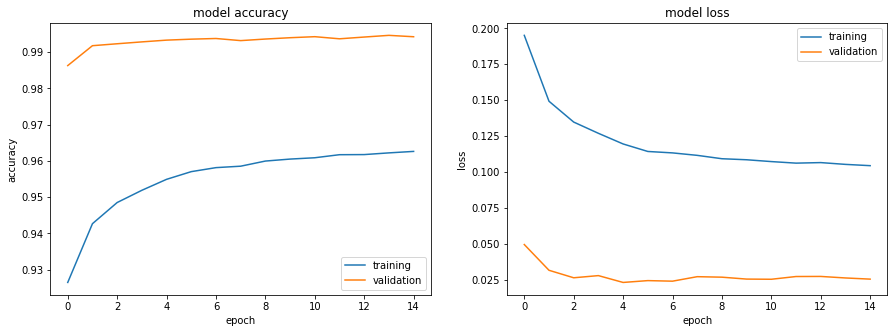

In [42]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

### 3. Auto Encoder

To build the autoencoder we will have to first encode the input image and add different encoded and decoded layer to build the deep autoencoder

#### 3.1 Reshape the training and test dataset to original shape

In [44]:
x_train = x_train.reshape((len(x_train), -1))
x_test = x_test.reshape((len(x_test), -1))

Reshaping to original input image size

#### 3.2 Encoding the original data

Encoder : reduce the input dimensions and compress the input data into an encoded representation.

In [45]:
encoded = Dense(units=128, activation='relu')(input_img)
encoded = Dense(units=64, activation='relu')(encoded)

Applying two hidden layers to deep neural network,for reduce the input dimensions and compress the input data into an encoded representation.

For all the hidden layers for the encoder we use relu activation function for non-linearity.

#### 3.3 Decode the encoded the data to be close to the original shape

Decoder : reconstruct the data from the encoded representation to be as close to the original input as possible.

In [46]:
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(784, activation='sigmoid')(decoded)

Applying two hidden layers to deep neural network.for reconstruct the data from the encoded representation to be as close to the original input as possible.

For all the hidden layers for the encoder we use relu activation function for non-linearity.

In the final layer where we reconstruct the input image we use sigmoid activation function. The output layer needs to predict the probability of an output which needs to either 0 or 1 and hence we use sigmoid activation function.

#### 3.4 Auto Encoder

Autoencoder is an unsupervised artificial neural network that efficiently compress and encode data then reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible.

#### 3.4.1 Configures the model for training.

In [47]:
autoencoder = Model(input_img, decoded)

#Configures the model for training.
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

We create the autoencoder with input image as the input. Output will be the final decoder layer.

We compile the autoencoder model with adadelta optimizer.As pixels have a value of 0 0r 1 we use binary_crossentropy as the loss function.We use accuracy as the metrics used for the performance of the model.

#### 3.4.2 View the structure of the deep autoencoder model

In [48]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_26 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_27 (Dense)             (None, 784)               101136    
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________


#### 3.4.2 Fiting the Autoencoder

In [49]:
autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                verbose=1,
                callbacks=[es,checkpoint],
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 12s 204us/step - loss: 0.1772 - accuracy: 0.8003 - val_loss: 0.1239 - val_accuracy: 0.8093
Epoch 2/30
60000/60000 [==============================] - 12s 204us/step - loss: 0.1140 - accuracy: 0.8119 - val_loss: 0.1034 - val_accuracy: 0.8120
Epoch 3/30
60000/60000 [==============================] - 13s 221us/step - loss: 0.1010 - accuracy: 0.8134 - val_loss: 0.0950 - val_accuracy: 0.8129
Epoch 4/30
60000/60000 [==============================] - 13s 222us/step - loss: 0.0946 - accuracy: 0.8140 - val_loss: 0.0912 - val_accuracy: 0.8134
Epoch 5/30
60000/60000 [==============================] - 13s 219us/step - loss: 0.0907 - accuracy: 0.8143 - val_loss: 0.0876 - val_accuracy: 0.8135
Epoch 6/30
60000/60000 [==============================] - 13s 218us/step - loss: 0.0879 - accuracy: 0.8145 - val_loss: 0.0854 - val_accuracy: 0.8137
Epoch 7/30
60000/60000 [==============================] 

We finally train the autoencoder using the training data with 30 epochs and batch size of 32.

#### 3.4.3 Visualization of auto encoder resutls

Predicting the test set using autoencoder to obtain the reconstructed image.

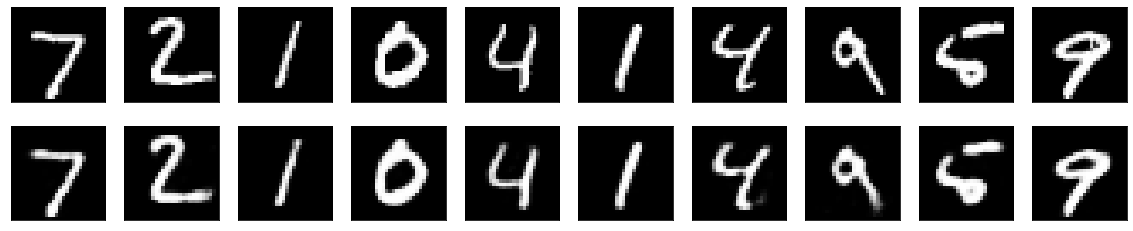

In [50]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Showing the original input,reconstructed images

### 3.5 Encoder

#### 3.5.1 Encode the original data then summarize the data

In [51]:
encoder = Model(input_img, encoded)

We extract the encoder which takes input image as the original data and the output is the encoded image of dimension 64 (reconstructed data)

#### 3.5.2 View the structure of the deep encoder model

In [52]:
encoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
Total params: 108,736
Trainable params: 108,736
Non-trainable params: 0
_________________________________________________________________


#### 3.5.2 predicting the encoder data

Generates output predictions for the x_test

In [53]:
encoded_test_data = encoder.predict(x_test)

predict the test set using the encoder to view the encoded images.

#### 3.5.3 Visualization of encoder data

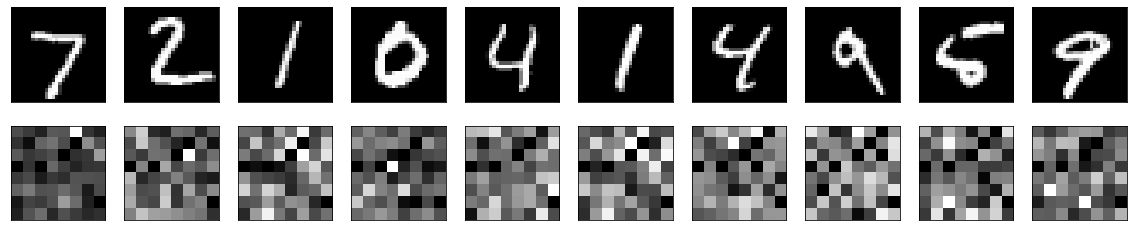

In [54]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded images
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(encoded_test_data[i].reshape(8,8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

Showing the original input, encoded images

### 3.6 Classifier for encoded data

### 3.6.1 Definition of Image Classifier Model

In [96]:
def image_classifier_model(input_size,no_classes):
    input_ = Input(shape=(input_size,))
    x = Dense(32, kernel_initializer=init_mode,activation=activation)(input_)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(no_classes,
                   kernel_initializer=init_mode,
                   activation='softmax')(x)
    model = Model(input_, outputs)
    
    # Compile model
    # optimizer = optimizer(lr=learn_rate, momentum=momentum)
    # Optimizer     -- Adam
    # Loss function -- categorical_crossentropy
    # Metrics       -- Accuracy 
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Creating the image classifier model for classifier on encoded dataset

we encode the encoded data to 32 input data by applying hidden layers to model.

The output layer needs to predict the probability of an output using sigmoid function.

For all the hidden layers for the model we use relu activation function for non-linearity.

We compile the model with adam optimizer.

As pixels have a value of 0 0r 1 we use categorical_crossentropy as the loss function

We use accuracy as the metrics used for the performance of the model.

#### 3.6.1 Creating an Image Classifier Model

In [97]:
# create model
classifier = image_classifier_model(encoded_test_data.shape[1], y_train.shape[1])

#### 3.6.2 View the structure of the image classifier model

In [98]:
# Print the model
classifier.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 10)                330       
Total params: 2,410
Trainable params: 2,410
Non-trainable params: 0
_________________________________________________________________


#### 3.6.3 Predicting the encoder data

Generates output predictions for the x_train

In [99]:
encoded_oiginal_data = encoder.predict(x_train)

#### 3.6.4 Trains the model for a fixed number of epochs (iterations on a dataset).

In [100]:
history = classifier.fit(encoded_oiginal_data, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    callbacks=[es,checkpoint],
                    validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 4s 66us/step - loss: 2.1464 - accuracy: 0.1616 - val_loss: 1.8475 - val_accuracy: 0.6070
Epoch 2/30
54000/54000 [==============================] - 3s 61us/step - loss: 2.1098 - accuracy: 0.1703 - val_loss: 1.6231 - val_accuracy: 0.6892
Epoch 3/30
54000/54000 [==============================] - 3s 61us/step - loss: 2.0969 - accuracy: 0.1738 - val_loss: 1.6248 - val_accuracy: 0.7025
Epoch 4/30
54000/54000 [==============================] - 3s 61us/step - loss: 2.0956 - accuracy: 0.1754 - val_loss: 1.5422 - val_accuracy: 0.6612
Epoch 5/30
54000/54000 [==============================] - 3s 61us/step - loss: 2.0975 - accuracy: 0.1752 - val_loss: 1.5800 - val_accuracy: 0.6915
Epoch 6/30
54000/54000 [==============================] - 3s 61us/step - loss: 2.0999 - accuracy: 0.1728 - val_loss: 1.6056 - val_accuracy: 0.6937
Epoch 7/30
54000/54000 [==============================] - 3s 60us/ste

#### 3.6.5 Visualization of model loss and model accuracy 

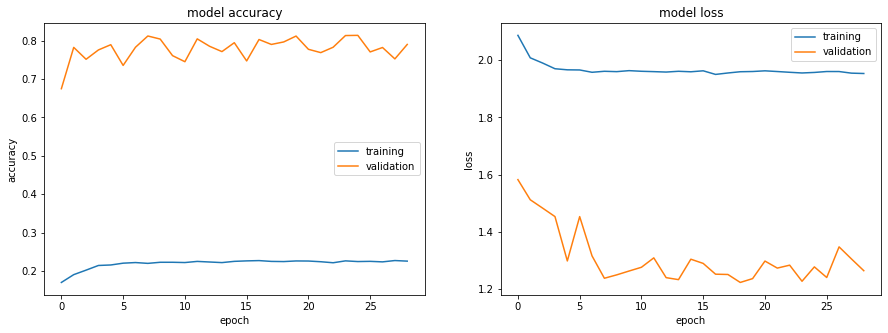

In [92]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [93]:
X_test = classifier.predict(encoded_test_data)

In [94]:
loss, accuracy  = classifier.evaluate(encoded_test_data, y_test, verbose=1)

10000/10000 [==============================] - 0s 18us/step


In [95]:
print('Test loss: %.4f' % loss)
print('Test accuracy: %.4f' % accuracy)

Test loss: 1.2839
Test accuracy: 0.7643
